In [1]:
import os
import matplotlib.pyplot as plt
import cv2  # OpenCV for image processing

In [ ]:
image_size_full = 768 #256

In [2]:
import os
import torch
import numpy as np
import cv2  # OpenCV for image processing
from torch.utils.data import Dataset
from torchvision import transforms
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
import albumentations as A
from albumentations.pytorch import ToTensorV2


class SegmentationDataset(Dataset):
    def __init__(self, images_path, masks_path, target_size=(image_size_full, image_size_full), augment = True):
        self.images_path = images_path
        self.masks_path = masks_path
        self.image_files = sorted(os.listdir(images_path))
        self.mask_files = sorted(os.listdir(masks_path))
        self.target_size = target_size  # Target size for resizing

        self.augment = augment

        # self.augmentations = A.Compose([
        #     A.HorizontalFlip(p=0.5),
        #     A.Rotate(limit=15),
        #     A.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
        #     A.RandomBrightnessContrast(p=0.2),
        #     A.RandomResizedCrop(height=target_size[0], width=target_size[1], scale=(0.8, 1.0)),
        #     A.GaussianBlur(blur_limit=3, p=0.3),
        #     A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),
        #     A.CLAHE(clip_limit=2, p=0.3),
        #     A.Perspective(scale=(0.05, 0.1), p=0.3),
        #     A.GridDistortion(p=0.3),
        #     A.PadIfNeeded(min_height=target_size[0], min_width=target_size[1], border_mode=cv2.BORDER_REFLECT_101, p=0.3),
        # ], additional_targets={'mask': 'image'})

        self.augmentations = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.Rotate(limit=5, p=0.5),
            A.RandomBrightnessContrast(p=0.1),
            A.GaussianBlur(blur_limit=1, p=0.1),
            A.GaussNoise(var_limit=(5.0, 20.0), p=0.1),
            A.CLAHE(clip_limit=1, p=0.1),
        ], additional_targets={'mask': 'image'})




       
    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load image and mask
        image_path = os.path.join(self.images_path, self.image_files[idx])
        mask_path = os.path.join(self.masks_path, self.mask_files[idx])
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Assuming grayscale images
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)    # Assuming masks are also grayscale

        if self.target_size is not None:
            # Resize image and mask to target size
            image = cv2.resize(image, self.target_size, interpolation=cv2.INTER_LINEAR)
            mask = cv2.resize(mask, self.target_size, interpolation=cv2.INTER_NEAREST) # this should help maintaining the connectivity on the mask

        if self.augment:
            augmented = self.augmentations(image=image, mask=mask)
            image, mask = augmented['image'], augmented['mask']
            
        # Normalize image to range [0, 1]
        image = image.astype(np.float32) / 255.0
        
        # Transform mask values from 0, 128, 256 to 0, 1, 2
        mask = self.transform_mask(mask)

        # Generate all coordinates and their corresponding intensities and labels
        coords_intensities, labels = self.generate_all_coordinates_intensities_and_labels(image, mask)

        return coords_intensities, labels


    def transform_mask(self, mask):
        mask_transformed = np.zeros_like(mask)
        mask_transformed[mask == 0] = 0
        mask_transformed[mask == 128] = 1
        mask_transformed[mask == 255] = 2

        return mask_transformed

    def generate_all_coordinates_intensities_and_labels(self, image, mask):
        H, W = image.shape
        
        # Create a grid of coordinates
        y_coords, x_coords = np.meshgrid(np.arange(H), np.arange(W), indexing='ij')
        coords = np.stack((y_coords, x_coords), axis=-1).reshape(-1, 2)
        
        # Normalize coordinates to range [0, 1]
        coords = coords.astype(np.float32) / np.array([H, W], dtype=np.float32)
        
        # Flatten image and mask to get corresponding intensities and labels
        intensities = image.flatten()
        labels = mask.flatten()
        
        # Combine coordinates and intensities
        coords_intensities = np.hstack([coords, intensities.reshape(-1, 1)])
        
        # Convert to tensors
        coords_intensities = torch.tensor(coords_intensities, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.long)
        
        return coords_intensities, labels


c:\Users\Q540900\AppData\Local\anaconda3\envs\dlnnl3\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] Die angegebene Prozedur wurde nicht gefunden'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [3]:
from torch.utils.data import DataLoader

# Define paths to your image and mask directories
images_path = 'C:/Users/Q540900/Desktop/A.I. Master/Werkstudent/RAVIR Dataset/train/training_images' #'path/to/images'
masks_path = 'C:/Users/Q540900/Desktop/A.I. Master/Werkstudent/RAVIR Dataset/train/training_masks' #'path/to/masks'

# Create dataset and dataloader
batch_size = 4    # Adjust based on your GPU memory

dataset = SegmentationDataset(images_path, masks_path, target_size=(image_size_full, image_size_full))
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

coords_intensities, sampled_labels = next(iter(dataloader))
print(coords_intensities.shape, sampled_labels.shape)

torch.Size([4, 65536, 3]) torch.Size([4, 65536])


c:\Users\Q540900\AppData\Local\anaconda3\envs\dlnnl3\lib\site-packages\albumentations\augmentations\blur\transforms.py:184: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  warnings.warn(


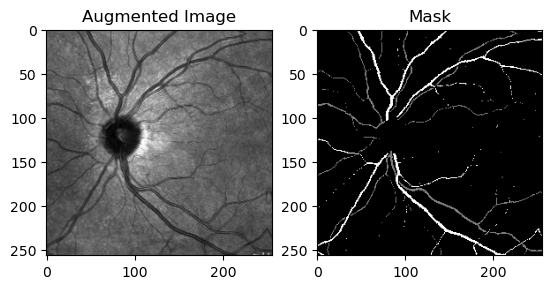

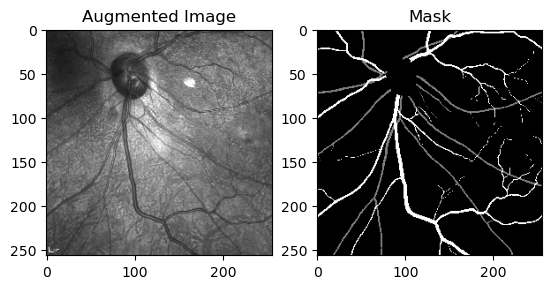

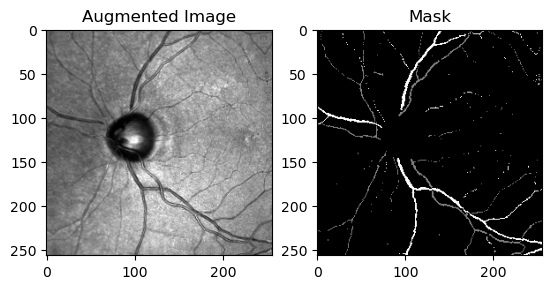

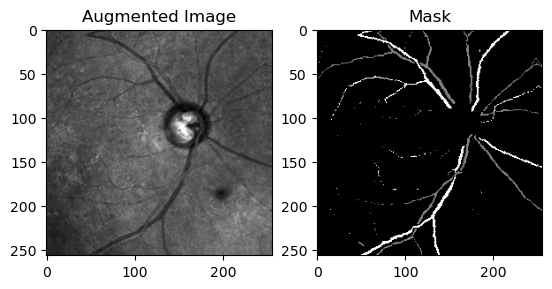

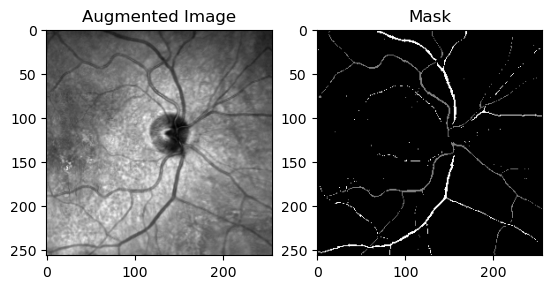

In [4]:
import matplotlib.pyplot as plt

def show_augmented_images(dataset, num_images=5):
    for i in range(num_images):
        coords_intensities, labels = dataset[i]
        image = coords_intensities[:, 2].reshape(dataset.target_size)
        mask = labels.reshape(dataset.target_size)
        
        fig, axs = plt.subplots(1, 2)
        axs[0].imshow(image, cmap='gray')
        axs[0].set_title('Augmented Image')
        axs[1].imshow(mask, cmap='gray')
        axs[1].set_title('Mask')
        plt.show()

# Visualizza alcune immagini augmentate
show_augmented_images(dataset)


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PositionalEncoding(nn.Module):
    def __init__(self, num_freqs):
        super(PositionalEncoding, self).__init__()
        self.num_freqs = num_freqs

    def forward(self, x):
        frequencies = torch.linspace(0, self.num_freqs - 1, self.num_freqs, device=x.device)
        frequencies = 2.0 ** frequencies
        x = x.unsqueeze(-1) * frequencies.unsqueeze(0).unsqueeze(0)
        x = torch.cat([torch.sin(x), torch.cos(x)], dim=-1)
        return x.view(x.shape[0], -1)
    
class AdaptiveDropout(nn.Module):
    def __init__(self, initial_p=0.5, decay_factor=0.95):
        super(AdaptiveDropout, self).__init__()
        self.p = initial_p
        self.decay_factor = decay_factor

    def forward(self, x):
        if self.training:
            return F.dropout(x, p=self.p, training=True)
        else:
            return x

    def step(self):
        self.p *= self.decay_factor  # Decrement dropout probability
    
# Sine Layer
class SineLayer(nn.Module):
    def __init__(self, in_features, out_features, omega_0=15.0):
        super(SineLayer, self).__init__()
        self.linear = nn.Linear(in_features, out_features)
        self.omega_0 = omega_0

    def forward(self, x):
        x = self.linear(x)
        x = torch.sin(self.omega_0 * x)
        return x

class INRSegmentationModel(nn.Module):
    def __init__(self, num_classes, hidden_dim=image_size_full, num_layers=5, num_freqs=10, initial_dropout_p=0.5):
        super(INRSegmentationModel, self).__init__()
        self.num_classes = num_classes
        self.pos_enc = PositionalEncoding(num_freqs)
        self.mlp = nn.ModuleList()
        input_dim = num_freqs * 2 * 2 + 1  # 2 for (x, y) and 2 for sin/cos, 1 for intensity

        # self.mlp.append(nn.Linear(input_dim, hidden_dim))
        # self.mlp.append(SineLayer(hidden_dim, hidden_dim))

        # Adding AdaptiveDropout
        self.dropouts = nn.ModuleList([AdaptiveDropout(initial_dropout_p) for _ in range(num_layers - 1)])

        self.mlp.append(nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            SineLayer(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim*hidden_dim),
            self.dropouts[0]
        ))

        for i in range(1, num_layers - 2):
            # self.mlp.append(nn.Linear(hidden_dim, hidden_dim))
            # self.mlp.append(SineLayer(hidden_dim, hidden_dim)) --> activation -1 +1 
            self.mlp.append(nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim),
                nn.ReLU(),
                nn.BatchNorm1d(hidden_dim*hidden_dim),
                self.dropouts[i]
            ))
        self.mlp.append(nn.Linear(hidden_dim, num_classes))

    def forward(self, coords_intensities):
        bs, ns, _ = coords_intensities.size()
        coords, intensities = coords_intensities[:, :, :-1], coords_intensities[:, :, -1].view((bs, ns,1))
        x = self.pos_enc(coords).view((bs, ns, -1))
        x = torch.cat([x, intensities], dim=-1)
        # print("Shape before first MLP:", x.shape)
        for layer in self.mlp[:-1]:
            x = layer(x)
            # print("Current shape in loop:", x.shape)
        x = self.mlp[-1](x)
        return x # Return logits without activation

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


In [6]:
import torch.nn.functional as F

class MultiClassDiceLoss(nn.Module):
    def __init__(self, num_classes, smooth=1):
        super(MultiClassDiceLoss, self).__init__()
        self.num_classes = num_classes
        self.smooth = smooth

    def forward(self, inputs, targets):
        # Convert class indices to one-hot encoding
        targets_one_hot = torch.zeros_like(inputs).scatter_(1, targets.unsqueeze(1), 1)
        
        # Apply softmax to get probabilities
        inputs = F.softmax(inputs, dim=1)
        
        # Flatten the inputs and targets for each class
        inputs = inputs.view(-1, self.num_classes)
        targets_one_hot = targets_one_hot.view(-1, self.num_classes)
        
        # Compute the intersection and union for each class
        intersection = (inputs * targets_one_hot).sum(dim=0)
        union = inputs.sum(dim=0) + targets_one_hot.sum(dim=0)
        
        # Compute the Dice coefficient for each class
        dice = (2. * intersection + self.smooth) / (union + self.smooth)
        
        # Average Dice coefficient across classes
        dice_loss = 1 - dice.mean()
        
        return dice_loss

In [7]:
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.optim.lr_scheduler import ReduceLROnPlateau

import torch.optim as optim

# Define your model
num_classes = 3 
num_layers = 6
hidden_dim = image_size_full
model = INRSegmentationModel(num_classes=num_classes, hidden_dim=hidden_dim, num_layers=num_layers).to(device)

# Use AdamW optimizer
# optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0001)

# Define your loss function
criterion = MultiClassDiceLoss(num_classes) # nn.CrossEntropyLoss()

# Define the cosine annealing learning rate scheduler
# scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=1, eta_min=1e-6)
# scheduler = CosineAnnealingLR(optimizer, T_max=100, eta_min=1e-6)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.3, patience=30, verbose=True)


num_epochs = 3000

losses = []


for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0  # To store the loss of each epoch
    for batch in dataloader:
        coords_intensities, labels = batch
        coords_intensities, labels = coords_intensities.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(coords_intensities)
        loss = criterion(outputs.view((-1, num_classes)), labels.view(-1))
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        

    # Average loss for the epoch
    epoch_loss /= len(dataloader)
    losses.append(epoch_loss)
    
    # Step the scheduler
    scheduler.step(epoch_loss)

    if epoch == 0 or (epoch+ 1) % 50 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

c:\Users\Q540900\AppData\Local\anaconda3\envs\dlnnl3\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch [1/3000], Loss: 0.7955
Epoch [50/3000], Loss: 0.6668
Epoch [100/3000], Loss: 0.6559
Epoch [150/3000], Loss: 0.6304
Epoch [200/3000], Loss: 0.6125
Epoch [250/3000], Loss: 0.5936
Epoch [300/3000], Loss: 0.5874
Epoch [350/3000], Loss: 0.6205
Epoch [400/3000], Loss: 0.6020
Epoch [450/3000], Loss: 0.5890
Epoch [500/3000], Loss: 0.5923
Epoch [550/3000], Loss: 0.5908
Epoch [600/3000], Loss: 0.6101
Epoch [650/3000], Loss: 0.5897
Epoch [700/3000], Loss: 0.5869
Epoch [750/3000], Loss: 0.5949
Epoch [800/3000], Loss: 0.5805
Epoch [850/3000], Loss: 0.5919
Epoch [900/3000], Loss: 0.5942
Epoch [950/3000], Loss: 0.6096
Epoch [1000/3000], Loss: 0.5927
Epoch [1050/3000], Loss: 0.6188
Epoch [1100/3000], Loss: 0.5931
Epoch [1150/3000], Loss: 0.5883
Epoch [1200/3000], Loss: 0.5820
Epoch [1250/3000], Loss: 0.5915
Epoch [1300/3000], Loss: 0.6064
Epoch [1350/3000], Loss: 0.6243
Epoch [1400/3000], Loss: 0.5992
Epoch [1450/3000], Loss: 0.5968
Epoch [1500/3000], Loss: 0.5786
Epoch [1550/3000], Loss: 0.5955

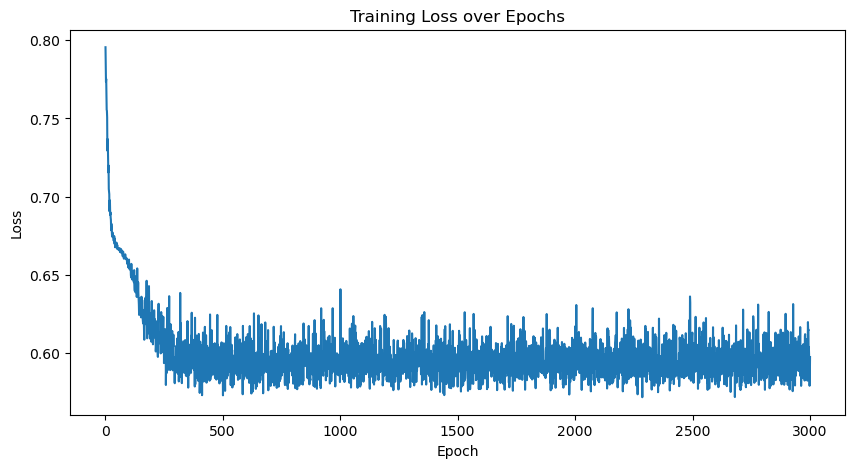

In [8]:
# Plotting the losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.show()

In [9]:
name_of_model = 'retina_segmentation_model_4-13.pth'

In [10]:
torch.save(model.state_dict(), name_of_model)

In [11]:
test_input = 'C:/Users/Q540900/Desktop/A.I. Master/Werkstudent/RAVIR Dataset/test'


In [12]:
import torch
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
from PIL import Image
import os
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

# Define your model
num_classes = 3 

# Define your loss function
criterion = MultiClassDiceLoss(num_classes) # nn.CrossEntropyLoss()

# Assumi che Siren sia già definito altrove nel codice
model = INRSegmentationModel(num_classes=num_classes, hidden_dim=hidden_dim, num_layers=num_layers).to(device)
model.load_state_dict(torch.load(name_of_model))
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def visualize_segmentation_mask(mask, title):
    """
    Visualizes the segmentation mask using Matplotlib.
    
    Args:
    mask (numpy.ndarray): 2D array of shape (H, W) with values 0, 1, or 2
    """
    # Define color mapping
    color_mapping = {
        0: [255, 255, 255], # White
        1: [0, 0, 255],     # Blue
        2: [255, 0, 0]      # Red
    }

    # Create an RGB image from the mask
    height, width = mask.shape
    rgb_image = np.zeros((height, width, 3), dtype=np.uint8)
    
    for class_value, color in color_mapping.items():
        rgb_image[mask == class_value] = color

    # Normalize the RGB values to the range [0, 1] for matplotlib
    rgb_image = rgb_image / 255.0

    # Display the image
    plt.imshow(rgb_image)
    plt.axis('off')  # Hide the axes
    plt.title(title)

def evaluate_model(model, coords_intensities, labels, img_size):
    model.eval()  # Set model to evaluation mode
    
    coords_intensities, labels = coords_intensities.to(device), labels.to(device)

    with torch.no_grad():
        outputs = model(coords_intensities.unsqueeze(0))

        print(outputs)
        loss = criterion(outputs.view((-1, num_classes)), labels.view(-1))

        predicted_mask = outputs.argmax(dim=-1).view(img_size).cpu().numpy()
        print(predicted_mask)

    # Plot the ground truth and predicted masks side by side
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    visualize_segmentation_mask(labels.view(img_size).cpu().numpy(), title="Ground Truth")

    plt.subplot(1, 2, 2)
    visualize_segmentation_mask(predicted_mask, title=f"Predicted Mask (DiceLoss = {loss.item():.3f})")
    
    plt.show()

c:\Users\Q540900\AppData\Local\anaconda3\envs\dlnnl3\lib\site-packages\albumentations\augmentations\blur\transforms.py:184: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  warnings.warn(


tensor([[[10.5415, -3.2416, -6.3980],
         [ 8.8230, -2.6327, -5.8255],
         [ 9.3026, -3.0472, -5.9033],
         ...,
         [ 8.6402, -2.5875, -5.6849],
         [10.5502, -3.1769, -6.4493],
         [10.0206, -3.2752, -6.3172]]])
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


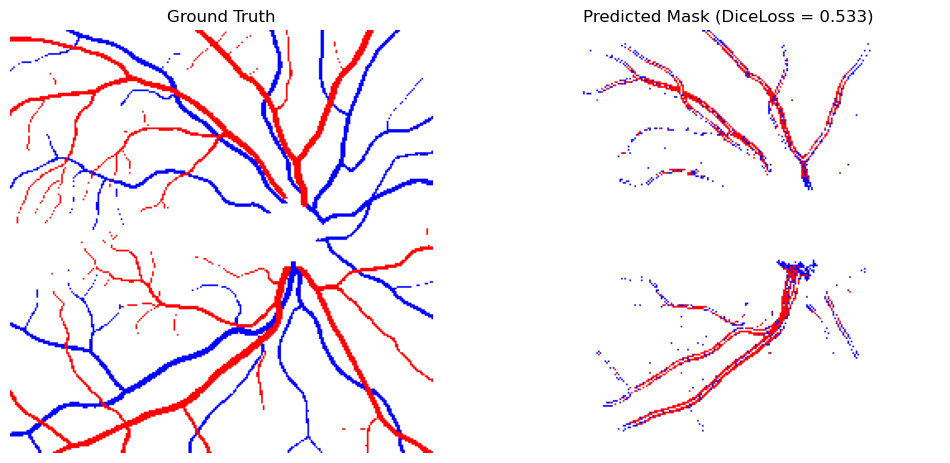

In [13]:
dataset2 = SegmentationDataset(images_path, masks_path, target_size=(image_size_full, image_size_full), augment=False)
eg_img, eg_mask = dataset2[0]
evaluate_model(model, eg_img, eg_mask, img_size=(image_size_full, image_size_full))

1) not include the sinelayer everytime
2) plays with the scheduler --> avoid local minima
3) not normalize --> avoid smooth convergence 
4) add augmentation techniques 
5) different retina dataset --> https://paperswithcode.com/dataset/hrf

meeting on 05.07

1. CrossEntropy or DiceLoss or FocalLoss